In [78]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim



all_class = [[0, 10, 20, 30, 40],
             [1, 11, 21, 31, 41],
             [2, 12, 22, 32, 42]]


selected_classes=sum(all_class, [])
label_mapping = {}
label_idx = 0
for st in all_class:
    for orig_label in st:
        label_mapping[orig_label] = label_idx
        label_idx += 1


print(label_mapping)


cifar100_classes = torchvision.datasets.CIFAR100(root='./data', download=False).classes


transform_test = transforms.Compose([

    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



test_set = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=False, transform=transform_test
)


selected_indices_test = [
    idx for idx, (_, label) in enumerate(test_set)
    if label in selected_classes
]
#selected_indices_test=selected_indices_test[:100]

for i in selected_indices_test:
    test_set.targets[i]=label_mapping[test_set.targets[i]]

# 创建子集数据集
filtered_test_set = Subset(test_set, selected_indices_test)
test_loader = DataLoader(filtered_test_set, batch_size=32, shuffle=False, num_workers=2)
print('Finish data loading')
#print(f"Testing data size: {len(filtered_test_set)}")


{0: 0, 10: 1, 20: 2, 30: 3, 40: 4, 1: 5, 11: 6, 21: 7, 31: 8, 41: 9, 2: 10, 12: 11, 22: 12, 32: 13, 42: 14}
Finish data loading


In [79]:
class CNN_0(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_0, self).__init__()
        self.conv0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  
        self.bn0 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  
        self.bn2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  
        self.bn3= nn.BatchNorm2d(512)


        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(512 * 2 * 2, 256)  
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn0(self.conv0(x))))

        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 64x64 -> 32x32

        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        


        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
class MetaModel(nn.Module):
    def __init__(self, input_dim=15, hidden_dim1=128, hidden_dim2=64, num_classes=15):
        super(MetaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [80]:
from transformers import ViTForImageClassification,SwinForImageClassification
def create_filter_list_vit(file_list,device):
    """
    load the filter model from file pathes 
    """
    result=[]
    for f in file_list:
        model = ViTForImageClassification.from_pretrained(f,num_labels=3)
        model.to(device)
        model.eval()
        result.append(model)
    return result
def create_filter_list_swin(file_list,device):
    """
    load the filter model from file pathes 
    """
    result=[]
    for f in file_list:
        model = SwinForImageClassification.from_pretrained(f,num_labels=3)
        model.to(device)
        model.eval()
        result.append(model)
    return result
def create_classifier_list(file_list,device):
    result=[]
    # load classifiers
    for f in file_list:
        model =CNN_0() # 
        model.load_state_dict(torch.load(f))
        model.to(device)
        model.eval()
        result.append(model)
    return result
        



In [81]:
def classifier_result(model,input_tensor,classifier_num):
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, dim=1)
        return classifier_num*5+predicted_class.item()
    

def merged_model(input_tensor, classifier_list, filter_model_list):
    """
    geive the prediction of input image using 3 classifiers and a 
    model to decide which classifier to chose
    """
    filter_tensor = torchvision.transforms.functional.resize(input_tensor, (224, 224))
    
    #print(filter_tensor)
    pre_set=set()
    result=[]
    n=len(filter_model_list)
    for model in filter_model_list:
        with torch.no_grad():
            output = model(filter_tensor)
            logits = output.logits if hasattr(output, "logits") else output
            probabilities = F.softmax(logits, dim=1)
            max_prob, predicted_class = torch.max(probabilities, dim=1)
            max_prob = max_prob.item()
            predicted_class=predicted_class.item()
            pre_set.add(predicted_class)
            result.append([predicted_class,max_prob])
    
    confidence_score=0
    for x in result:
        confidence_score+=x[1]
    confidence_score/=n # weight 1/n
    cond_threshold=0.9
    #print(confidence_score)
    if len(pre_set)!=1 or confidence_score<=cond_threshold:
        #return -1
        #return pieline2(input_tensor,classifier_list,device)
        return pipeline_meta(input_tensor,classifier_list,device)
    else:
        #return -1
        return classifier_result(classifier_list[result[0][0]],input_tensor,result[0][0])

def get_meta_data(input,classifier_list):
    """
    create the data as the input of meta model
    """
    with torch.no_grad():
        model_outputs = []
        for model in classifier_list:
                output = model(input)
                model_outputs.append(output)

        combined_outputs = torch.cat(model_outputs, dim=1)
    return combined_outputs



def pipeline_meta(input_tensor, classifier_list,device):
    model=MetaModel()
    model.load_state_dict(torch.load("model/taskA/meta_model/meta_model_1.pth", weights_only=False))

    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(get_meta_data(input_tensor,classifier_list))
        val, predicted = torch.max(outputs, dim=1)
    #if val<0.9:
        #return pieline2(input_tensor, classifier_list,device)
    return predicted.item()



def pieline2(input_tensor, classifier_list,device):
    result=-1
    max_confidence=-1
    m=0
    for model in classifier_list:
        with torch.no_grad():
            output = model(input_tensor)
            logits = output.logits if hasattr(output, "logits") else output
            probabilities = F.softmax(logits, dim=1)
            max_prob, predicted_class = torch.max(probabilities, dim=1)
            max_prob = max_prob.item()
            if max_prob>=max_confidence:
                result=m*5+predicted_class.item()
                max_confidence=max_prob
        m+=5
    #if max_confidence<0.8:
        #return pipeline_meta(input_tensor, classifier_list,device)
    return result


    

filter_file_list=[
"model/taskA/gating_network/filter_model_1/"
]
classifier_file_list=[
'model/taskA/model1/model_weights_CNN_0.pth',
'model/taskA/model2/model_weights_CNN_0.pth',
'model/taskA/model3/model_weights_CNN_0.pth'

]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filter_list=create_filter_list_swin(filter_file_list,device)

classifier_list=create_classifier_list(classifier_file_list,device)







In [82]:


def test(test_set,classifier_list,filter_list,device):
    total=0
    correct=0
    with torch.no_grad():
        for i in range(len(test_set)):
            image, label = test_set[i] 
            image = image.unsqueeze(0).to(device) 
            #label = torch.tensor([label], device=device)
            output= merged_model(image,classifier_list,filter_list)
            #_, predicted = torch.max(output, 1)
            if output==-1:
                continue
            total += 1
            correct += (output == label)
            #if output not in rever_map_A:
               #print(output)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(total)

test(filtered_test_set,classifier_list,filter_list,device)

Test Accuracy: 90.60%
1500


index of the sample displayed [1303, 397, 386, 549, 597, 1113, 1365, 134, 1117, 1164]
Displaying 10 samples: 


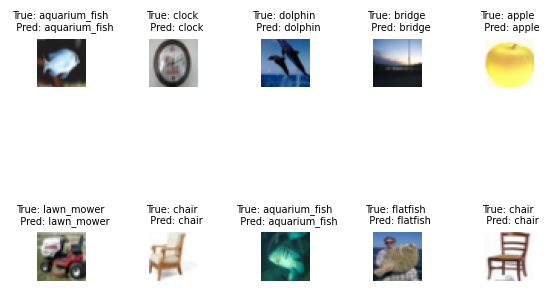

In [83]:
import random
import matplotlib.pyplot as plt
op_map_A={
    0: 'apple',
    10: 'bowl',
    20: 'chair',
    30: 'dolphin',
    40: 'lamp',
    1: 'aquarium_fish',
    11: 'boy',
    21: 'chimpanzee',
    31: 'elephant',
    41: 'lawn_mower',
    2: 'baby',
    12: 'bridge',
    22: 'clock',
    32: 'flatfish',
    42: 'leopard'
}
#{0: 0, 10: 1, 20: 2, 30: 3, 40: 4, 1: 5, 11: 6, 21: 7, 31: 8, 41: 9, 2: 10, 12: 11, 22: 12, 32: 13, 42: 14}
rever_map_A={
    0: 0,
    1: 10,
    2: 20,
    3: 30,
    4: 40,
    5: 1,
    6: 11,
    7: 21,
    8: 31,
    9: 41,
    10: 2,
    11: 12,
    12: 22,
    13: 32,
    14: 42
}
def display_sample(test_set, classifier_list, filter_list, device, display_num=10):
    random.seed(42)
    rd_list = [i for i in range(len(test_set))]
    random.shuffle(rd_list)
    sample_list = rd_list[:display_num]
    print(f'index of the sample displayed {sample_list}')
    
    display_samples = []
    for i in sample_list:
        image, label = test_set[i]
        image = image.unsqueeze(0).to(device)  
        output = merged_model(image, classifier_list, filter_list) 
        display_samples.append((image.squeeze().cpu(), op_map_A[rever_map_A[label]], op_map_A[rever_map_A[output]]))
    
    print(f'Displaying {display_num} samples: ')
    for i, (img, true_label, pred_label) in enumerate(display_samples):
        plt.subplot(2, 5, i + 1)  
        

        img = img.permute(1, 2, 0) 
        img = img / 2 + 0.5

        plt.imshow(img.numpy()) 
        plt.title(f"True: {true_label} \n  Pred: {pred_label}", fontsize=7)
        plt.axis('off') 

    plt.subplots_adjust(wspace=1.3, hspace=0.1)
    plt.show()


display_sample(filtered_test_set, classifier_list, filter_list, device, display_num=10)